# ACIT4610 Problem Statement 2
This assignment focuses on optimizing a financial portfolio with the single objective of
maximizing expected return. You will implement and compare different versions of
Evolutionary Programming (EP) and Evolutionary Strategies (ES), including the (μ + λ) and
(μ, λ) strategies, to determine which approach yields the best portfolio allocation.

In [15]:
""" Setup the environment for the notebook """
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import yahoo_finance_data_loader as yfdl

data_location = os.path.join(os.getcwd(), 'data', 'raw')

## Data Preprocessing Section

1. Download the data

In [16]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and
    compute monthly returns.
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'interval': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NOD.OL']


In [17]:
manager = yfdl.TickerManager(STOCK_TICKERS, **DATA_PERIOD)
manager['AAPL'].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Currency
Date,,,,,,,,,
2018-01-02 00:00:00-05:00,40.074352,40.578343,39.862391,40.568920,102223600,0.0,0.0,AAPL,USD
2018-01-03 00:00:00-05:00,40.632509,41.108240,40.498270,40.561855,118071600,0.0,0.0,AAPL,USD
2018-01-04 00:00:00-05:00,40.634877,40.853903,40.526545,40.750278,89738400,0.0,0.0,AAPL,USD
2018-01-05 00:00:00-05:00,40.846831,41.301363,40.754982,41.214226,94640000,0.0,0.0,AAPL,USD
2018-01-08 00:00:00-05:00,41.061150,41.357891,40.962232,41.061150,82271200,0.0,0.0,AAPL,USD


In [18]:
manager['NOD.OL'].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Currency
Date,,,,,,,,,
2018-01-02 00:00:00+01:00,3.980524,4.113208,3.952092,4.075298,348643,0.0,0.0,NOD.OL,NOK
2018-01-03 00:00:00+01:00,4.075298,4.122685,4.037388,4.122685,334311,0.0,0.0,NOD.OL,NOK
2018-01-04 00:00:00+01:00,4.141640,4.321711,4.132163,4.321711,567401,0.0,0.0,NOD.OL,NOK
2018-01-05 00:00:00+01:00,4.321711,4.383315,4.189028,4.369099,378158,0.0,0.0,NOD.OL,NOK
2018-01-08 00:00:00+01:00,4.369099,4.397531,4.226937,4.326450,289170,0.0,0.0,NOD.OL,NOK


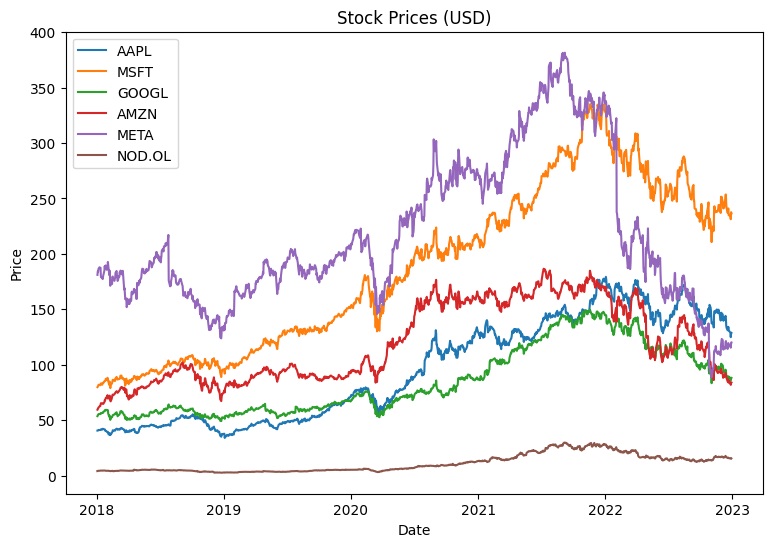

In [19]:
plt.figure(figsize=(9, 6))
for ticker in STOCK_TICKERS:
    plt.plot(manager[ticker]['Close'], label=ticker)
plt.title('Stock Prices (USD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [20]:
"""
manager = yfdl.FinanceLoader(STOCK_TICKERS, **DATA_PERIOD).download(data_location)
print(f"TOTAL TICKERS: {manager.get_ticker_count()}")
manager.finance_data.head()
"""

'\nmanager = yfdl.FinanceLoader(STOCK_TICKERS, **DATA_PERIOD).download(data_location)\nprint(f"TOTAL TICKERS: {manager.get_ticker_count()}")\nmanager.finance_data.head()\n'